# load mouse kidney sciCAR dataset into scanpy

In [2]:
!ls ../rawdata/GSE117089_RAW/*mouse*

../rawdata/GSE117089_RAW/GSM3271044_RNA_mouse_kidney_cell.txt.gz
../rawdata/GSE117089_RAW/GSM3271044_RNA_mouse_kidney_gene_count.txt.gz
../rawdata/GSE117089_RAW/GSM3271044_RNA_mouse_kidney_gene.txt.gz
../rawdata/GSE117089_RAW/GSM3271045_ATAC_mouse_kidney_cell.txt.gz
../rawdata/GSE117089_RAW/GSM3271045_ATAC_mouse_kidney_peak_count.txt.gz
../rawdata/GSE117089_RAW/GSM3271045_ATAC_mouse_kidney_peak.txt.gz


In [12]:
!conda install memory_profiler --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.8
  latest version: 4.6.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - memory_profiler


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    memory_profiler-0.55.0     |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          26 KB

The following NEW packages will be INSTALLED:

  memory_profiler    conda-forge/noarch::memory_profiler-0.55.0-py_0



memory_profiler-0.55 | 26 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [20]:
%load_ext memory_profiler
import sys, os

import pandas as pd
pd.set_option('display.max_rows', 10, 'display.max_columns', 99)

import scipy as sp
from scipy.sparse import csr_matrix

import scanpy as sc
sc.set_figure_params(format='png')

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
datafolder = '../rawdata/GSE117089_RAW/'

In [21]:
pd.read_csv(datafolder + 'GSM3271044_RNA_mouse_kidney_cell.txt.gz')
    #makes you wonder why certain cells were excluded from clustering

,sample,source,replicate,experiment,tsne_1,tsne_2,cell_name
0,coRNA-RNA-plate1-001.TCGGCGTCGT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
1,coRNA-RNA-plate1-001.CATGACTCAA,Mouse,Replicate 1,coassay,2.808426,-45.948924,Loop of Henle cells
2,coRNA-RNA-plate1-001.CGCCAGGCAT,Mouse,Replicate 1,coassay,-4.660380,-41.004499,Loop of Henle cells
3,coRNA-RNA-plate1-001.CTGGTTGGTT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
4,coRNA-RNA-plate1-001.CCAGGCTCTT,Mouse,Replicate 2,coassay,10.309332,11.143745,Proximal tubule S1/S2 cells
...,...,...,...,...,...,...,...
13888,coRNA-RNA-plate8-096.GCTCGAATCA,Mouse,Replicate 2,coassay,34.541703,-6.368314,Proximal tubule S3 cells (type 2)
13889,coRNA-RNA-plate8-096.GACCAATGCG,Mouse,Replicate 1,coassay,-3.729165,30.804146,Proximal tubule S1/S2 cells
13890,coRNA-RNA-plate8-096.AATACCAGTT,Mouse,Replicate 1,coassay,-14.379572,33.444072,Proximal tubule S1/S2 cells
13891,coRNA-RNA-plate8-096.TAGAATAGCC,Mouse,Replicate 2,coassay,NaN,NaN,NaN


### GEO data

some of the data is stored as sparsematrix format (scRNAseq uses this too): 
 - https://math.nist.gov/MatrixMarket/formats.html

Scipy can read [Sparse Matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) via `scipy.io.mmread()`
 - CSC (Compressed Sparse Column) and CSR (Compressed Sparse Row) are more compact and efficient, but difficult to construct "from scratch". 
   - CSC is more efficient at accessing column-vectors or column operations, generally, as it is stored as arrays of columns and their value at each row.
   - CSR matrices are the opposite; stored as arrays of rows and their values at each column, and are more efficient at accessing row-vectors or row operations.
 - COO (Coordinate) and DOK (Dictionary of Keys) are easier to construct, and can then be converted to CSC or CSR via `matrix.tocsc()` or `matrix.tocsr()`. 


Apparently for selecting a single element, dok, is fastest (counting the conversion time). This format is actually a dictionary, which of course has fast element access. 

But if you are frequently accessing whole rows, or whole columns, or iterating over rows or columns, you need to read the docs more carefully, and may be do your own time tests of typical arrays. 

If you are setting values, not just reading them, timings and even implementation can be different. You will get an efficiency warning if you try to change a 0 element of a csr or csc format.

### Read scATAC into anndata object

In [22]:
%%time 

atac_counts = sp.io.mmread(datafolder + "GSM3271045_ATAC_mouse_kidney_peak_count.txt.gz")
    # 252,741 peaks (rows) by 13,395 cells (cols)
    #min=0, mode=0, max=5557.0
    #scipy.sparse.coo.coo_matrix

#print(atac_counts)
#  (1200, 0)	2.0
#  (1777, 0)	2.0
#  (5227, 0)	1.0
#  (7777, 0)	2.0
#  (8953, 0)	2.0

CPU times: user 29.7 s, sys: 0 ns, total: 29.7 s
Wall time: 29.7 s


In [31]:
atac_counts.get_shape()

(252741, 13395)

In [29]:
a_T = atac_counts.transpose()

In [30]:
a_T.get_shape()

(13395, 252741)

In [45]:
%%time
%memit atac = sc.read_mtx(datafolder + "GSM3271045_ATAC_mouse_kidney_peak_count.txt.gz")
atac

peak memory: 1162.00 MiB, increment: 440.86 MiB
CPU times: user 32.2 s, sys: 286 ms, total: 32.5 s
Wall time: 32.6 s


In [35]:
type(atac)

anndata.base.AnnData

In [36]:
type(atac.X)

scipy.sparse.csr.csr_matrix

In [37]:
type(atac.obs)

pandas.core.frame.DataFrame

In [39]:
atac.obs

""
0
1
2
3
4
...
252736
252737
252738
252739


In [38]:
type(atac.var)

pandas.core.frame.DataFrame

In [40]:
atac.var

""
0
1
2
3
4
...
13390
13391
13392
13393


In [46]:
atac = atac.T

In [47]:
type(atac)

anndata.base.AnnData

In [48]:
type(atac.X)

scipy.sparse.csr.csr_matrix

In [49]:
type(atac.obs)

pandas.core.frame.DataFrame

In [50]:
atac.obs

""
0
1
2
3
4
...
13390
13391
13392
13393


In [51]:
type(atac.var)

pandas.core.frame.DataFrame

In [52]:
atac.var

""
0
1
2
3
4
...
252736
252737
252738
252739


In [53]:
atac

AnnData object with n_obs × n_vars = 13395 × 252741 

In [131]:
atac.obs = pd.read_csv(datafolder + 'GSM3271045_ATAC_mouse_kidney_cell.txt.gz', 
                       dtype={'sample':str, 
                              'replicate':'category'})
atac.obs.set_index('sample', str, inplace = True) #anndata wants indexes as strings
atac.obs

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


,replicate
sample,
coRNA-RNA-plate1-052.CGTAAGGAGT,Replicate 1
coRNA-RNA-plate1-052.ACTCCGCCAA,Replicate 1
coRNA-RNA-plate1-052.GGCTCGAGAT,Replicate 2
coRNA-RNA-plate1-052.CGCCAGGCAT,Replicate 1
coRNA-RNA-plate1-052.CATGACTCAA,Replicate 1
...,...
coRNA-RNA-plate7-063.GAGGTCGGTT,Replicate 1
coRNA-RNA-plate7-063.AGCAAGAACC,Replicate 1
coRNA-RNA-plate7-063.GCTCGAATCA,Replicate 2


In [130]:
atac.var = pd.read_csv(datafolder + 'GSM3271045_ATAC_mouse_kidney_peak.txt.gz', 
                       dtype={'id':str, 
                              'chr':'category', 
                              'start':int, 
                              'end':int})
atac.var.set_index('id', str, inplace = True) #anndata wants indexes as strings
atac.var
    #some redundant columns there... but whatever...

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


,peak,chr,start,end
id,,,,
1,GL456210.1-58882-59082,GL456210.1,58882,59082
2,GL456210.1-110303-110503,GL456210.1,110303,110503
3,GL456210.1-123592-123792,GL456210.1,123592,123792
4,GL456210.1-136519-136719,GL456210.1,136519,136719
5,GL456210.1-147592-147792,GL456210.1,147592,147792
...,...,...,...,...
252737,chrY-90805057-90805302,chrY,90805057,90805302
252738,chrY-90808722-90809017,chrY,90808722,90809017
252739,chrY-90810774-90813153,chrY,90810774,90813153


In [76]:
atac.var.index #note the now quoted values 

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '252732', '252733', '252734', '252735', '252736', '252737', '252738',
       '252739', '252740', '252741'],
      dtype='object', name='id', length=252741)

In [77]:
atac

AnnData object with n_obs × n_vars = 13395 × 252741 
    obs: 'replicate'
    var: 'peak', 'chr', 'start', 'end'

In [80]:
sys.getsizeof(atac)

59376667

### Read scRNA into anndata object

In [82]:
%%time
%memit rna = sc.read_mtx(datafolder + "GSM3271044_RNA_mouse_kidney_gene_count.txt.gz").T

peak memory: 1535.63 MiB, increment: 348.47 MiB
CPU times: user 22.2 s, sys: 205 ms, total: 22.4 s
Wall time: 22.5 s


In [83]:
rna

AnnData object with n_obs × n_vars = 13893 × 49584 

In [132]:
rna.var = pd.read_csv(datafolder + 'GSM3271044_RNA_mouse_kidney_gene.txt.gz', 
                      dtype={'gene_id':str,
                             'gene_type':'category',
                             'gene_short_name':'category'})
rna.var.set_index('gene_id', str, inplace = True) #anndata wants indexes as strings
rna.var
    #some redundant columns there... but whatever...

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


,gene_type,gene_short_name
gene_id,,
ENSMUSG00000102693.1,TEC,4933401J01Rik
ENSMUSG00000064842.1,snRNA,Gm26206
ENSMUSG00000051951.5,protein_coding,Xkr4
ENSMUSG00000102851.1,processed_pseudogene,Gm18956
ENSMUSG00000103377.1,TEC,Gm37180
...,...,...
ENSMUSG00000064367.1,protein_coding,mt-Nd5
ENSMUSG00000064368.1,protein_coding,mt-Nd6
ENSMUSG00000064369.1,Mt_tRNA,mt-Te


In [136]:
#not all gene short names are unique
rna.var['gene_short_name'].unique().shape

(49491,)

In [139]:
#duplicate short names
rna.var[rna.var.duplicated(subset='gene_short_name', keep=False)]

,gene_type,gene_short_name
gene_id,,
ENSMUSG00000065629.2,snoRNA,Gm24826
ENSMUSG00000104827.1,snoRNA,Gm24826
ENSMUSG00000064612.2,snoRNA,Gm26457
ENSMUSG00000105060.1,snoRNA,Gm26457
ENSMUSG00000107979.1,lincRNA,Zfp813-ps
...,...,...
ENSMUSG00000064400.2,snoRNA,Gm23927
ENSMUSG00000074985.1,pseudogene,Olfr1452-ps1
ENSMUSG00000109148.1,polymorphic_pseudogene,Olfr1452-ps1


In [128]:
rna.obs = pd.read_csv(datafolder + 'GSM3271044_RNA_mouse_kidney_cell.txt.gz', 
                      dtype={'sample':str, 
                             'source':'category',
                             'replicate':'category',
                             'experiment':'category',
                             'cell_name':'category'})
rna.obs.set_index('sample', str, inplace = True) #anndata wants indexes as strings
rna.obs

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


,source,replicate,experiment,tsne_1,tsne_2,cell_name
sample,,,,,,
coRNA-RNA-plate1-001.TCGGCGTCGT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
coRNA-RNA-plate1-001.CATGACTCAA,Mouse,Replicate 1,coassay,2.808426,-45.948924,Loop of Henle cells
coRNA-RNA-plate1-001.CGCCAGGCAT,Mouse,Replicate 1,coassay,-4.660380,-41.004499,Loop of Henle cells
coRNA-RNA-plate1-001.CTGGTTGGTT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
coRNA-RNA-plate1-001.CCAGGCTCTT,Mouse,Replicate 2,coassay,10.309332,11.143745,Proximal tubule S1/S2 cells
...,...,...,...,...,...,...
coRNA-RNA-plate8-096.GCTCGAATCA,Mouse,Replicate 2,coassay,34.541703,-6.368314,Proximal tubule S3 cells (type 2)
coRNA-RNA-plate8-096.GACCAATGCG,Mouse,Replicate 1,coassay,-3.729165,30.804146,Proximal tubule S1/S2 cells
coRNA-RNA-plate8-096.AATACCAGTT,Mouse,Replicate 1,coassay,-14.379572,33.444072,Proximal tubule S1/S2 cells


In [89]:
rna.obs.info() #fewer non-null values than can be explained by intersection of 2 modalities

<class 'pandas.core.frame.DataFrame'>
Index: 13893 entries, coRNA-RNA-plate1-001.TCGGCGTCGT to coRNA-RNA-plate8-096.GGCTATTCGA
Data columns (total 6 columns):
source        13893 non-null object
replicate     13893 non-null object
experiment    13893 non-null object
tsne_1        10727 non-null float64
tsne_2        10727 non-null float64
cell_name     10727 non-null object
dtypes: float64(2), object(4)
memory usage: 1.4+ MB


In [91]:
#11,296 cell barcodes with both data modality
rna.obs.index.intersection(atac.obs.index)

Index(['coRNA-RNA-plate1-001.TCGGCGTCGT', 'coRNA-RNA-plate1-001.CATGACTCAA',
       'coRNA-RNA-plate1-001.CGCCAGGCAT', 'coRNA-RNA-plate1-001.CTGGTTGGTT',
       'coRNA-RNA-plate1-001.CCAGGCTCTT', 'coRNA-RNA-plate1-001.GATTCCGGAA',
       'coRNA-RNA-plate1-001.CTGAAGAGAC', 'coRNA-RNA-plate1-001.ACGCTTCTCT',
       'coRNA-RNA-plate1-001.TGGCAGAAGT', 'coRNA-RNA-plate1-001.ACGTTGAATG',
       ...
       'coRNA-RNA-plate8-096.ACGCTTCTCT', 'coRNA-RNA-plate8-096.GGCTTCTGGA',
       'coRNA-RNA-plate8-096.ATCTAGGTTC', 'coRNA-RNA-plate8-096.ACTGGTAGAT',
       'coRNA-RNA-plate8-096.TTCTCTGAGA', 'coRNA-RNA-plate8-096.GCTCGAATCA',
       'coRNA-RNA-plate8-096.GACCAATGCG', 'coRNA-RNA-plate8-096.AATACCAGTT',
       'coRNA-RNA-plate8-096.TAGAATAGCC', 'coRNA-RNA-plate8-096.GGCTATTCGA'],
      dtype='object', name='sample', length=11296)

In [92]:
#15,992 cell barcodes with either modality
rna.obs.index.union(atac.obs.index)

Index(['coRNA-RNA-plate1-001.ACGCTTCTCT', 'coRNA-RNA-plate1-001.ACGTTGAATG',
       'coRNA-RNA-plate1-001.AGGACTGCGA', 'coRNA-RNA-plate1-001.AGGCCGGTAA',
       'coRNA-RNA-plate1-001.CATGACTCAA', 'coRNA-RNA-plate1-001.CCAGGCTCTT',
       'coRNA-RNA-plate1-001.CCTGAGAGCA', 'coRNA-RNA-plate1-001.CGAATCTCCT',
       'coRNA-RNA-plate1-001.CGCCAGGCAT', 'coRNA-RNA-plate1-001.CTCGGAGCAA',
       ...
       'coRNA-RNA-plate8-096.GATTCCGGAA', 'coRNA-RNA-plate8-096.GCCATCAACT',
       'coRNA-RNA-plate8-096.GCTCGAATCA', 'coRNA-RNA-plate8-096.GGCTATTCGA',
       'coRNA-RNA-plate8-096.GGCTTCTGGA', 'coRNA-RNA-plate8-096.TAGAATAGCC',
       'coRNA-RNA-plate8-096.TCTATCGGTA', 'coRNA-RNA-plate8-096.TCTCTCATCC',
       'coRNA-RNA-plate8-096.TCTGACGAGG', 'coRNA-RNA-plate8-096.TTCTCTGAGA'],
      dtype='object', name='sample', length=15992)

In [115]:
a = atac.obs.index.str.split(r'[\.-]', expand=True)
print(a.levels[1], a.levels[2], a.levels[3], a.levels[4])

Index(['RNA'], dtype='object') Index(['plate1', 'plate2', 'plate3', 'plate4', 'plate5', 'plate6', 'plate7',
       'plate8'],
      dtype='object') Index(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013', '014', '015', '016', '017', '018', '019', '020',
       '021', '022', '023', '024', '025', '026', '027', '028', '029', '030',
       '031', '032', '033', '034', '035', '036', '037', '038', '039', '040',
       '041', '042', '043', '044', '045', '046', '047', '048', '049', '050',
       '051', '052', '053', '054', '055', '056', '057', '058', '059', '060',
       '061', '062', '063', '064', '065', '066', '067', '068', '069', '070',
       '071', '072', '073', '074', '075', '076', '077', '078', '079', '080',
       '081', '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096'],
      dtype='object') Index(['AAGCATCCTA', 'AAGTACGTTA', 'AATACCAGTT', 'AATCCGGTCA', 'AATCGAACTC',
       'AA

In [116]:
r = rna.obs.index.str.split(r'[\.-]', expand=True)
print(r.levels[1], r.levels[2], r.levels[3], r.levels[4])

Index(['RNA'], dtype='object') Index(['plate1', 'plate2', 'plate3', 'plate4', 'plate5', 'plate6', 'plate7',
       'plate8'],
      dtype='object') Index(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013', '014', '015', '016', '017', '018', '019', '020',
       '021', '022', '023', '024', '025', '026', '027', '028', '029', '030',
       '031', '032', '033', '034', '035', '036', '037', '038', '039', '040',
       '041', '042', '043', '044', '045', '046', '047', '048', '049', '050',
       '051', '052', '053', '054', '055', '056', '057', '058', '059', '060',
       '061', '062', '063', '064', '065', '066', '067', '068', '069', '070',
       '071', '072', '073', '074', '075', '076', '077', '078', '079', '080',
       '081', '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096'],
      dtype='object') Index(['AAGCATCCTA', 'AAGTACGTTA', 'AATACCAGTT', 'AATCCGGTCA', 'AATCGAACTC',
       'AA

In [117]:
a.levels[4].shape #would seem like 96well plate barcodes

(96,)

In [118]:
r.levels[4].shape #would seem like 96well plate barcodes

(96,)

In [104]:
96*8 #plates times wells (not sure what the split-pool scheme was)

768

In [122]:
#all seed barcodes are present in both modalities  
pd.Index(a.levels[4]).intersection(r.levels[4]).shape

(96,)

### What do the values look like (how sparse, what's the range?)

In [ ]:
a_array = a.toarray()

In [ ]:
sys.getsizeof(a_array)

In [ ]:
atac.X

# Example Analysis on anndata objects

In [150]:
atac

AnnData object with n_obs × n_vars = 13395 × 252741 
    obs: 'replicate'
    var: 'peak', 'chr', 'start', 'end'

In [149]:
rna

AnnData object with n_obs × n_vars = 13893 × 49584 
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_name'
    var: 'gene_type', 'gene_short_name'

In [172]:
sc.settings.n_jobs=4
sc.settings.set_figure_params(dpi=150, dpi_save=600, frameon=True, vector_friendly=True, fontsize=10, color_map=None, format='svg')

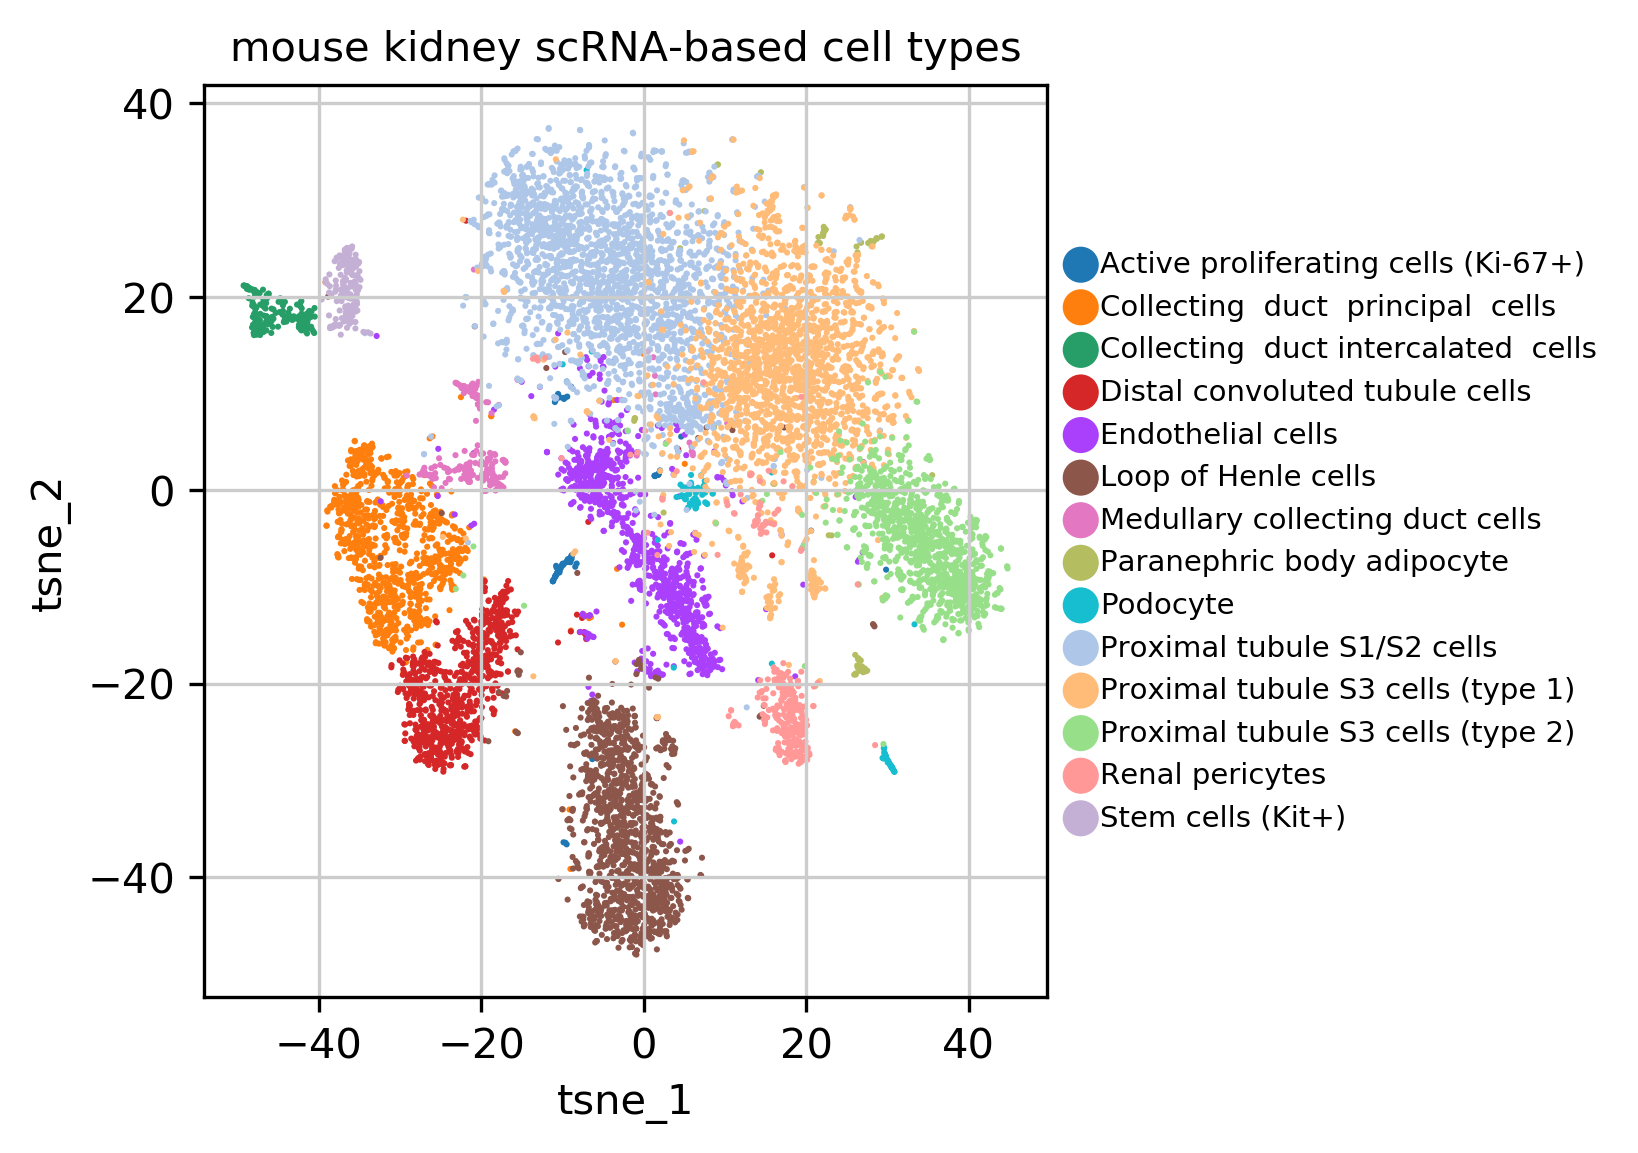

In [179]:
#plot existing tsne in rna data
sc.pl.scatter(rna, 
              x='tsne_1', y='tsne_2', color='cell_name', 
              title='mouse kidney scRNA-based cell types', 
              legend_fontsize=7) #legend_loc='on data'

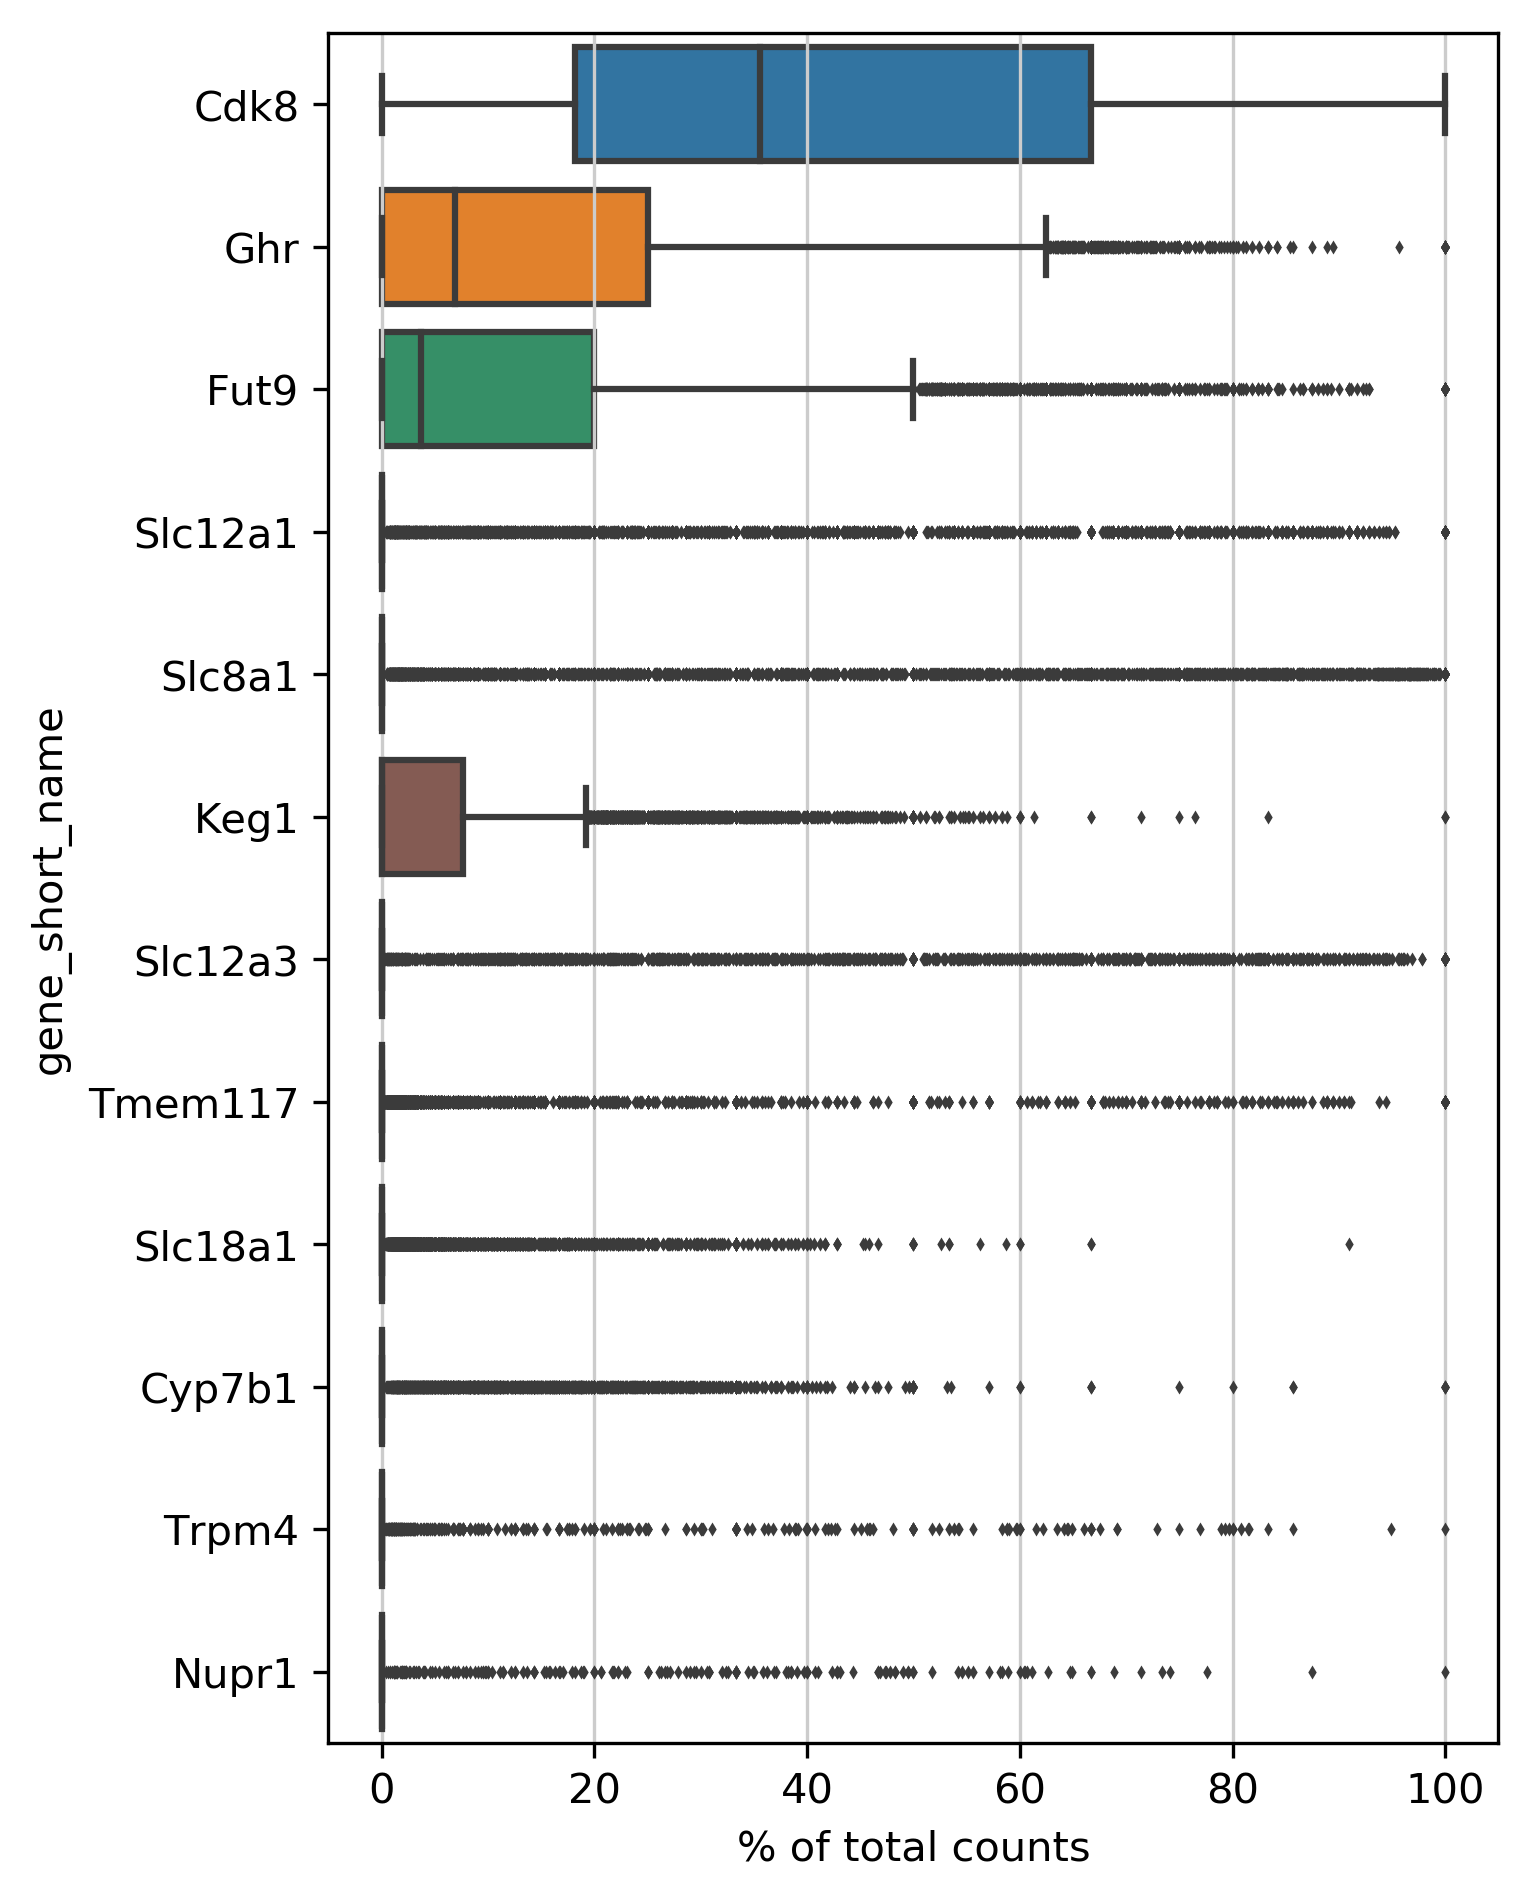

In [177]:
sc.pl.highest_expr_genes(rna, gene_symbols='gene_short_name')

In [159]:
%%time
%memit sc.pp.filter_genes_dispersion(rna)

peak memory: 1157.86 MiB, increment: 0.00 MiB
CPU times: user 122 ms, sys: 94.1 ms, total: 216 ms
Wall time: 369 ms


In [ ]:
sc.pl.filter_genes_dispersion(

#### Fetch Mitochondrial Genes

In [141]:
!conda install -c bioconda bioservices --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.8
  latest version: 4.6.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - bioservices


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alabaster-0.7.12           |             py_0          15 KB  conda-forge
    babel-2.6.0                |             py_1         5.6 MB  conda-forge
    bioservices-1.6.0          |             py_0         140 KB  bioconda
    colorama-0.4.1             |             py_0          15 KB  conda-forge
    colorlog-4.0.2             |        py37_1000          19 KB  conda-forge
    docutils-0.14              |        py37_1001         692 KB  conda-forge
    easydev-0.9.36             |             py_1          48 KB  conda-forge
    gevent-1.4.

In [143]:
#requires bioservices installed
mito_genes = sc.queries.mitochondrial_genes('useast.ensembl.org', 'mmusculus')

In [148]:
print(mito_genes, len(mito_genes))

Index(['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti',
       'mt-Tq', 'mt-Tm', 'mt-Nd2', 'mt-Tw', 'mt-Ta', 'mt-Tn', 'mt-Tc', 'mt-Ty',
       'mt-Co1', 'mt-Ts1', 'mt-Td', 'mt-Co2', 'mt-Tk', 'mt-Atp8', 'mt-Atp6',
       'mt-Co3', 'mt-Tg', 'mt-Nd3', 'mt-Tr', 'mt-Nd4l', 'mt-Nd4', 'mt-Th',
       'mt-Ts2', 'mt-Tl2', 'mt-Nd5', 'mt-Nd6', 'mt-Te', 'mt-Cytb', 'mt-Tt',
       'mt-Tp'],
      dtype='object', name='symbol') 37


#### Regress out batch

In [ ]:
# use the 'replicate' of each metadat with the scanpy's regress out tool

#### Run PAGA

In [181]:
%%time
%memit sc.pp.neighbors(rna, n_neighbors=50)

peak memory: 1263.95 MiB, increment: 42.33 MiB
CPU times: user 51.3 s, sys: 1.87 s, total: 53.2 s
Wall time: 49.8 s


In [186]:
%%time
%memit sc.tl.louvain(rna)

peak memory: 1435.74 MiB, increment: 94.29 MiB
CPU times: user 4.87 s, sys: 106 ms, total: 4.97 s
Wall time: 5.1 s


In [187]:
%%time
%memit sc.tl.paga(rna)

peak memory: 1400.73 MiB, increment: 58.94 MiB
CPU times: user 1.38 s, sys: 133 ms, total: 1.52 s
Wall time: 1.65 s


In [189]:
sc.pl.paga(rna,
    threshold=0,           
    solid_edges='connectivities_tree',
    dashed_edges='connectivities', 
    root='Stem cells (Kit+)',
    layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

NameError: name 'solid_edges' is not defined

In [190]:
%%time
%memit sc.tl.umap(rna, min_dist=0.1)

peak memory: 1269.63 MiB, increment: 1.54 MiB
CPU times: user 39.1 s, sys: 5.36 s, total: 44.4 s
Wall time: 35.9 s


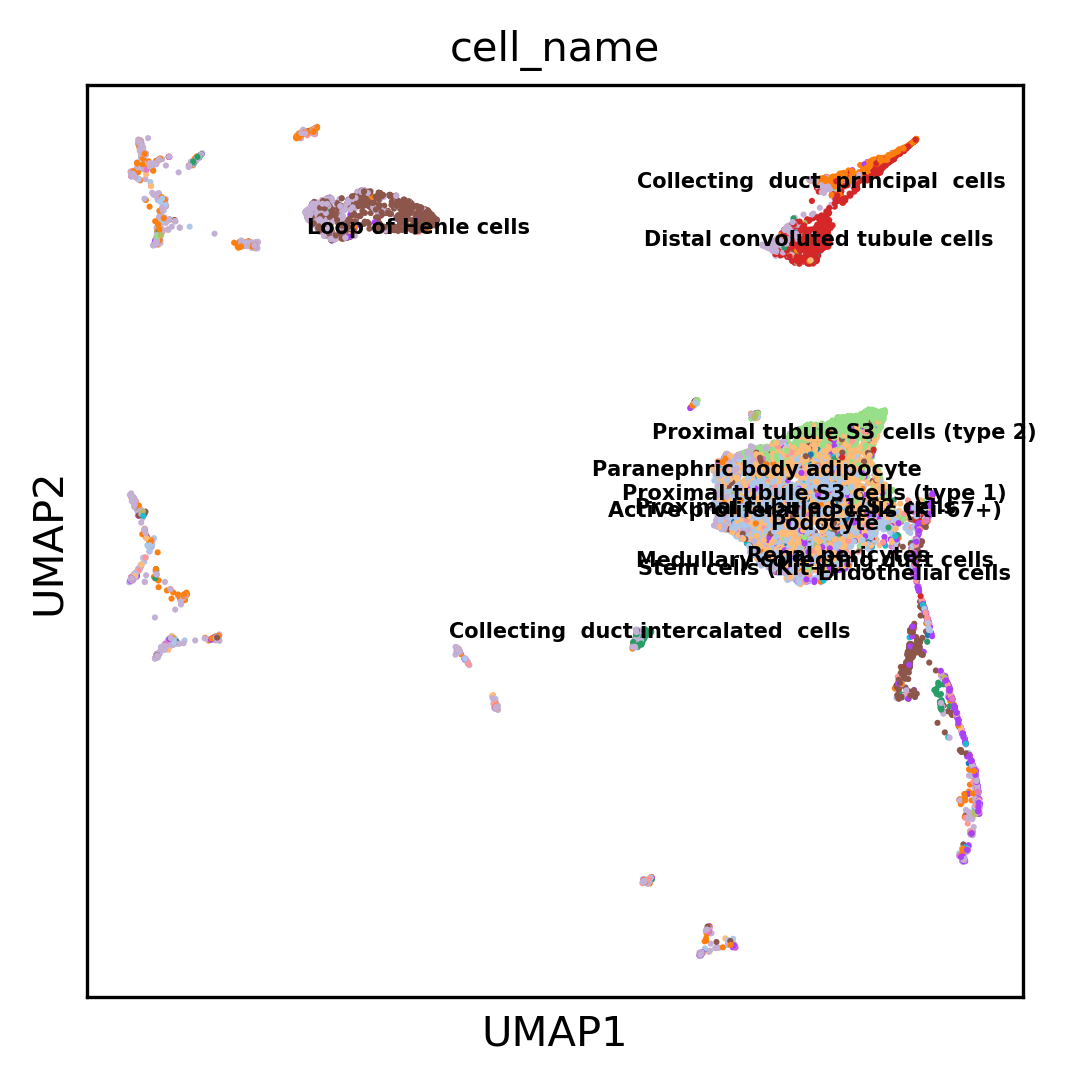

In [191]:
sc.pl.umap(rna, color='cell_name', legend_loc='on data', legend_fontsize=5)

In [202]:
!conda install -c grst phenograph --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.8
  latest version: 4.6.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - phenograph


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    phenograph-1.5.2_15a4f8ac  |                0         133 KB  grst
    ------------------------------------------------------------
                                           Total:         133 KB

The following NEW packages will be INSTALLED:

  phenograph         grst/linux-64::phenograph-1.5.2_15a4f8ac-0



phenograph-1.5.2_15a | 133 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [204]:
%%time
%memit rna.write('sciCAR_mouse_rna_scanpy.h5ad')

peak memory: 416.27 MiB, increment: 0.00 MiB
CPU times: user 145 ms, sys: 65.8 ms, total: 211 ms
Wall time: 474 ms


### cluster atac

In [192]:
%%time
%memit sc.pp.neighbors(atac, n_neighbors=50)

         Falling back to preprocessing with `sc.pp.pca` and default params.
peak memory: 27204.43 MiB, increment: 25934.80 MiB
CPU times: user 9min 19s, sys: 49.6 s, total: 10min 9s
Wall time: 2min 47s


In [193]:
%%time
%memit sc.tl.louvain(atac)

peak memory: 426.93 MiB, increment: 93.65 MiB
CPU times: user 4.18 s, sys: 273 ms, total: 4.46 s
Wall time: 5.32 s


In [194]:
%%time
%memit sc.tl.umap(atac, min_dist=0.1)

peak memory: 349.53 MiB, increment: 2.20 MiB
CPU times: user 22.8 s, sys: 4.13 s, total: 26.9 s
Wall time: 19.5 s


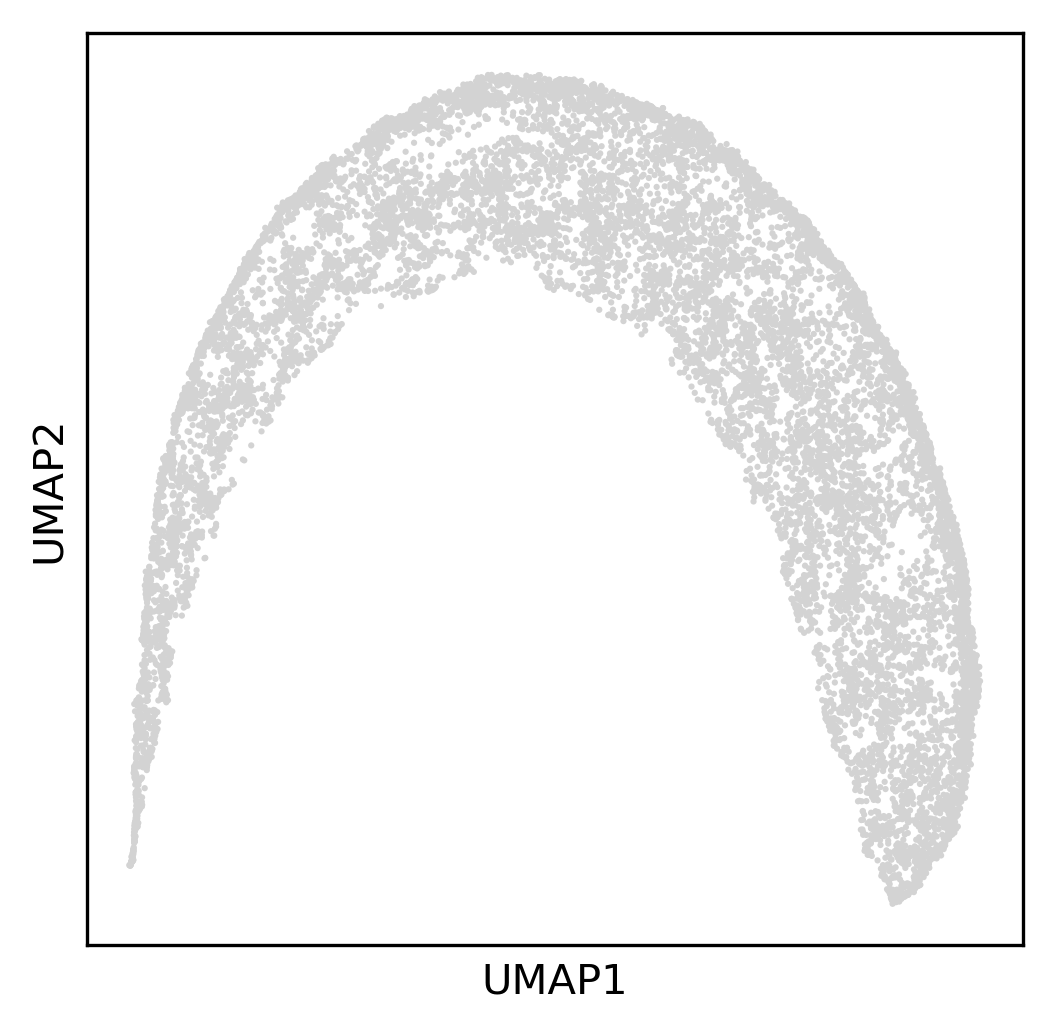

In [207]:
# atac on umap
sc.pl.umap(atac, legend_loc='right', legend_fontsize=5)

In [206]:
%%time
%memit atac.write('sciCAR_mouse_atac_scanpy.h5ad')

peak memory: 494.79 MiB, increment: 78.52 MiB
CPU times: user 4.43 s, sys: 440 ms, total: 4.87 s
Wall time: 7.62 s
